# Analyzing some DECam images with starlink streaks

In [102]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

from astropy import coordinates as coord
from astropy.time import Time
import astropy.units as u
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

### Use the butler to access a processed visit image and corresponding source catalog for one image
Note: this notebook runs on data that is on lsst-dev at present, not epyc

In [4]:
repo = '/project/mrawls/starlink/rerun/20200317'
butler = dafPersist.Butler(repo)

In [208]:
dataId = {'visit': 941420, 'ccd': 7}
calexp = butler.get('calexp', dataId=dataId)
src = butler.get('src', dataId=dataId)
psfRadius = calexp.getPsf().computeShape().getDeterminantRadius()

In [ ]:
print(psfRadius)


<IPython.core.display.Javascript object>


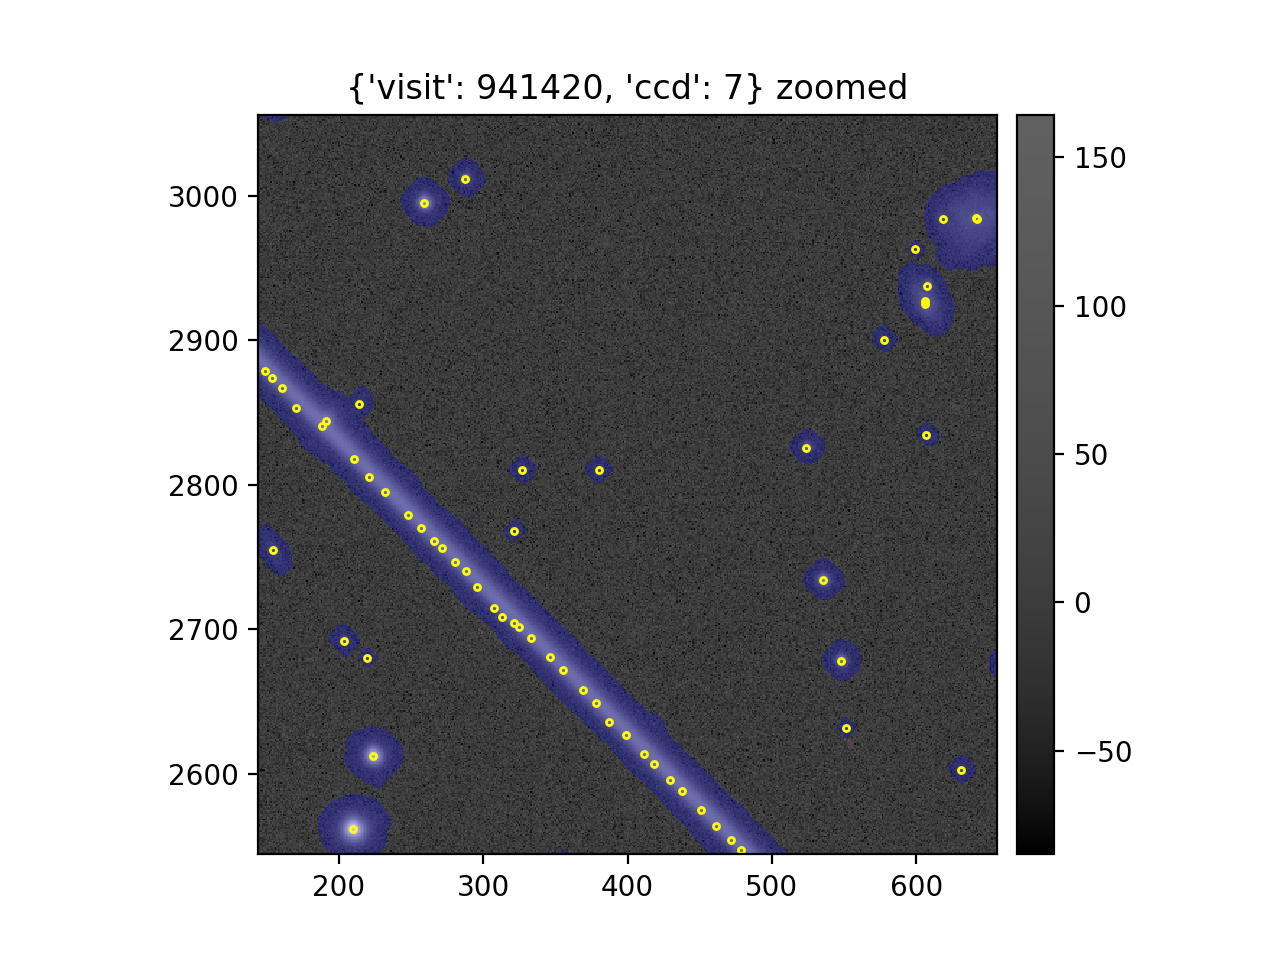

In [209]:
disp1 = afwDisplay.Display(1)
disp1.scale("asinh", "zscale", Q=8)
disp1.mtv(calexp, title=str(dataId) + ' zoomed')
disp1.zoom(8)
disp1.pan(400, 2800)
plt.plot(src['slot_Centroid_x'], src['slot_Centroid_y'], marker='o',
         mfc='None', ls='None', ms=psfRadius, color='yellow')
#disp1.dot('o', 450, 2750, size=psfRadius)  # another way to plot a dot

The satellite trail is masked as detected (blue). All the sources from the source catalog are plotted as open yellow circles sized to the image's PSF.

In [22]:
photoCalib = calexp.getPhotoCalib()
njyImage = photoCalib.calibrateImage(calexp.maskedImage)

All pixels in njyImage have values that correspond to their calibrated flux in nJy.

Similarly, we can make a flux calibrated catalog, with new `_flux`, `_fluxErr`, `_mag`, and `_magErr` fields.

In [26]:
calibratedCatalog = photoCalib.calibrateCatalog(src)

In [243]:
pixelScale = calexp.getWcs().getPixelScale()
pixelScale.asArcseconds()  # arcsec per pixel

0.2626266207112311

In [242]:
(psfRadius*pixelScale).asArcseconds()

0.5711639320878621

### Use visit info to compute sun location and phase angle

In [240]:
visitInfo = calexp.getInfo().getVisitInfo()
print(visitInfo.getBoresightAzAlt())
print(visitInfo.getBoresightRaDec())

(312.320400, +77.250000)
(84.201445, -21.204939)


In [241]:
boresight_raDec = visitInfo.getBoresightRaDec()

In [212]:
dateObs = visitInfo.getDate().toPython()

In [239]:
dateObsAstropy = Time(dateObs)
sky_coord = coord.SkyCoord(boresight_raDec.getRa().asDegrees()*u.deg, boresight_raDec.getDec().asDegrees()*u.deg)
location = coord.EarthLocation.of_site('Cerro Tololo Interamerican Observatory')
aa_frame = coord.AltAz(obstime=dateObsAstropy, location=location)
aa_coord = sky_coord.transform_to(aa_frame)
sun_coord = coord.get_sun(dateObsAstropy)
sun_aa = sun_coord.transform_to(aa_frame)

print('sun location: \n', sun_coord, sun_aa)
print('')
print('phase angle: \n', skyCoord.separation(sun_coord))

sun location: 
 <SkyCoord (GCRS: obstime=2020-03-06 00:05:52.410235, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (346.74903321, -5.67467956, 0.99206062)> <SkyCoord (AltAz: obstime=2020-03-06 00:05:52.410235, location=(1814303.74553723, -5214365.7436216, -3187340.56598756) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, m)
    (255.95285985, -12.40682634, 1.48411531e+11)>

phase angle: 
 56d11m27.2026s


### Rotate image so the streak is horizontal and we can plot the brightness profile
This is a clunky way to guesstimate how much to rotate the image by

In [92]:
coordUL = [153.2, 2879.2]  # 1 point from upper left of line, manually measured
coordLR = [1970.7, 1036.3]  # another point from lower right of line, manually measured
angle = np.arctan2(coordLR[1] - coordUL[1], coordLR[0] - coordUL[0]) * u.rad  # angle by which to rotate image
angle.to(u.deg)

<Quantity -45.39757662 deg>

Verify the line is roughly correct

<IPython.core.display.Javascript object>


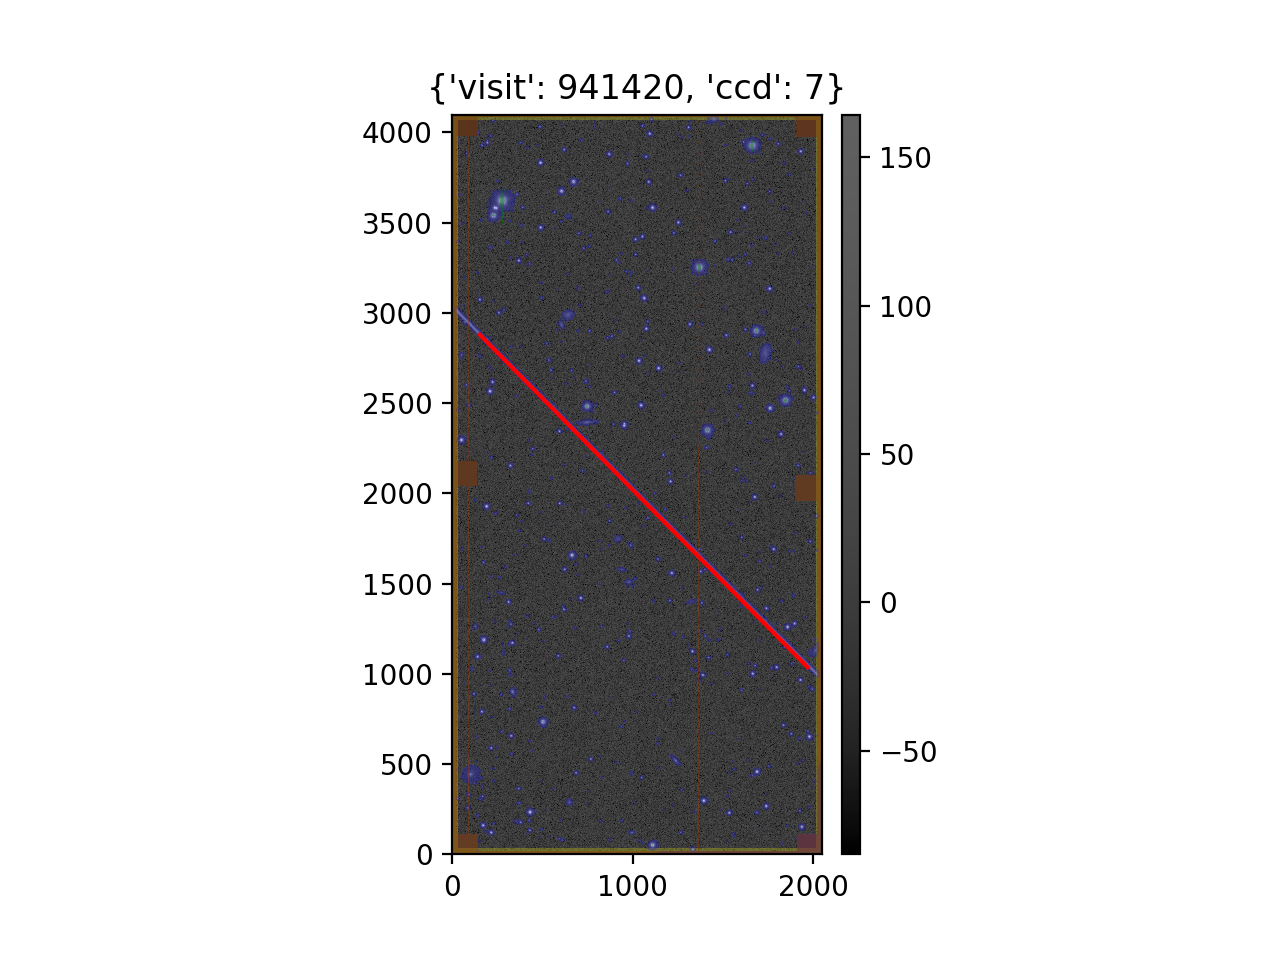

In [245]:
disp2 = afwDisplay.Display(2)
disp2.scale("asinh", "zscale", Q=8)
disp2.mtv(calexp, title=str(dataId))
plt.plot([coordUL[0], coordLR[0]], [coordUL[1], coordLR[1]], c='red')

### We now leave afw-land and work with a numpy image array

In [246]:
imageArray = njyImage.getImage().getArray()  # remember, the pixel values are real nJy! yay!

<IPython.core.display.Javascript object>


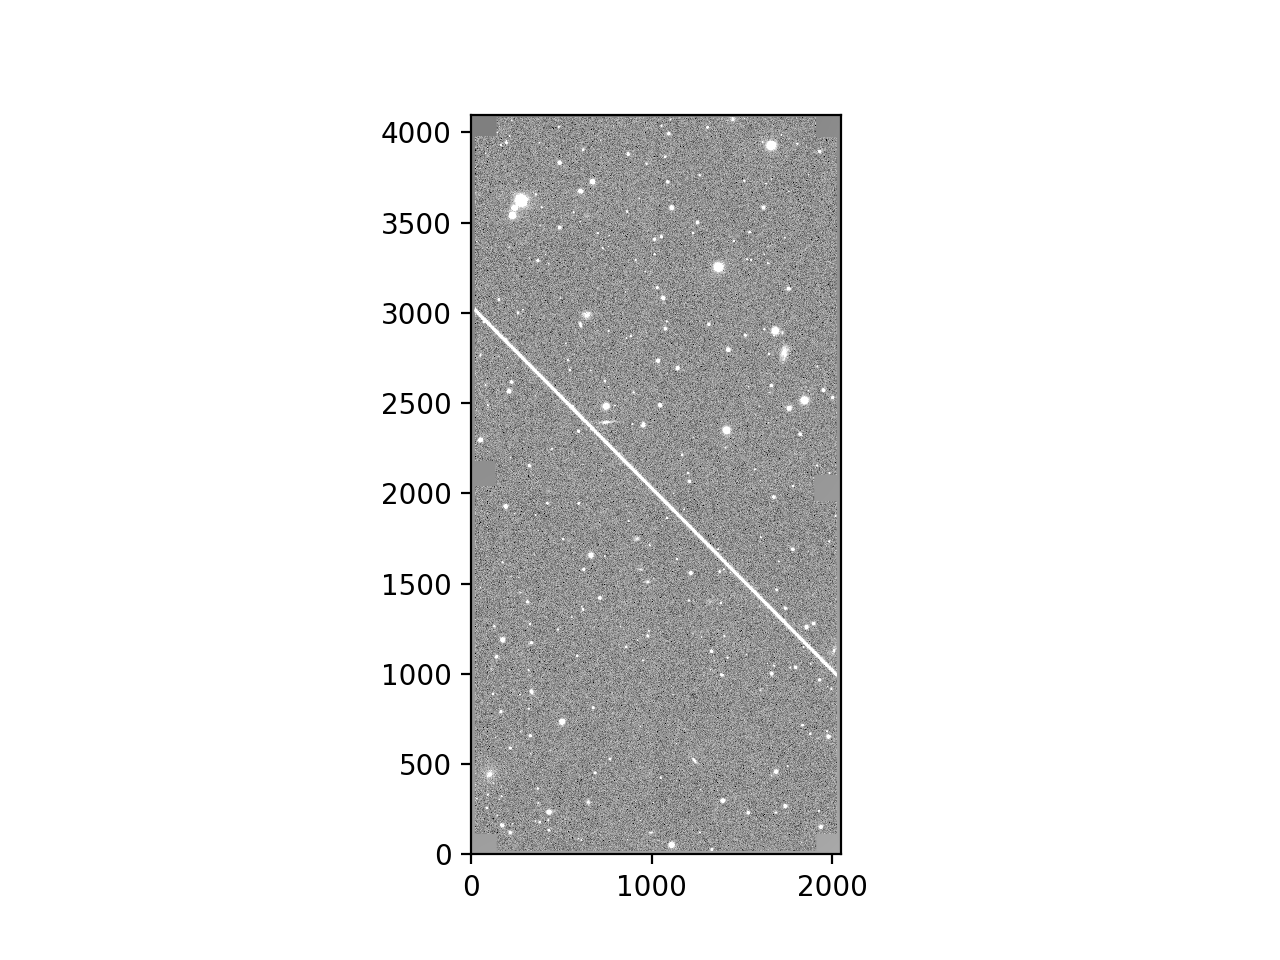

In [148]:
plt.figure()
norm = ImageNormalize(imageArray, interval=ZScaleInterval(), stretch=SqrtStretch())
plt.imshow(imageArray, cmap='gray', norm=norm, origin='lower')

In [149]:
rotatedArray = rotate(imageArray, angle)

<IPython.core.display.Javascript object>


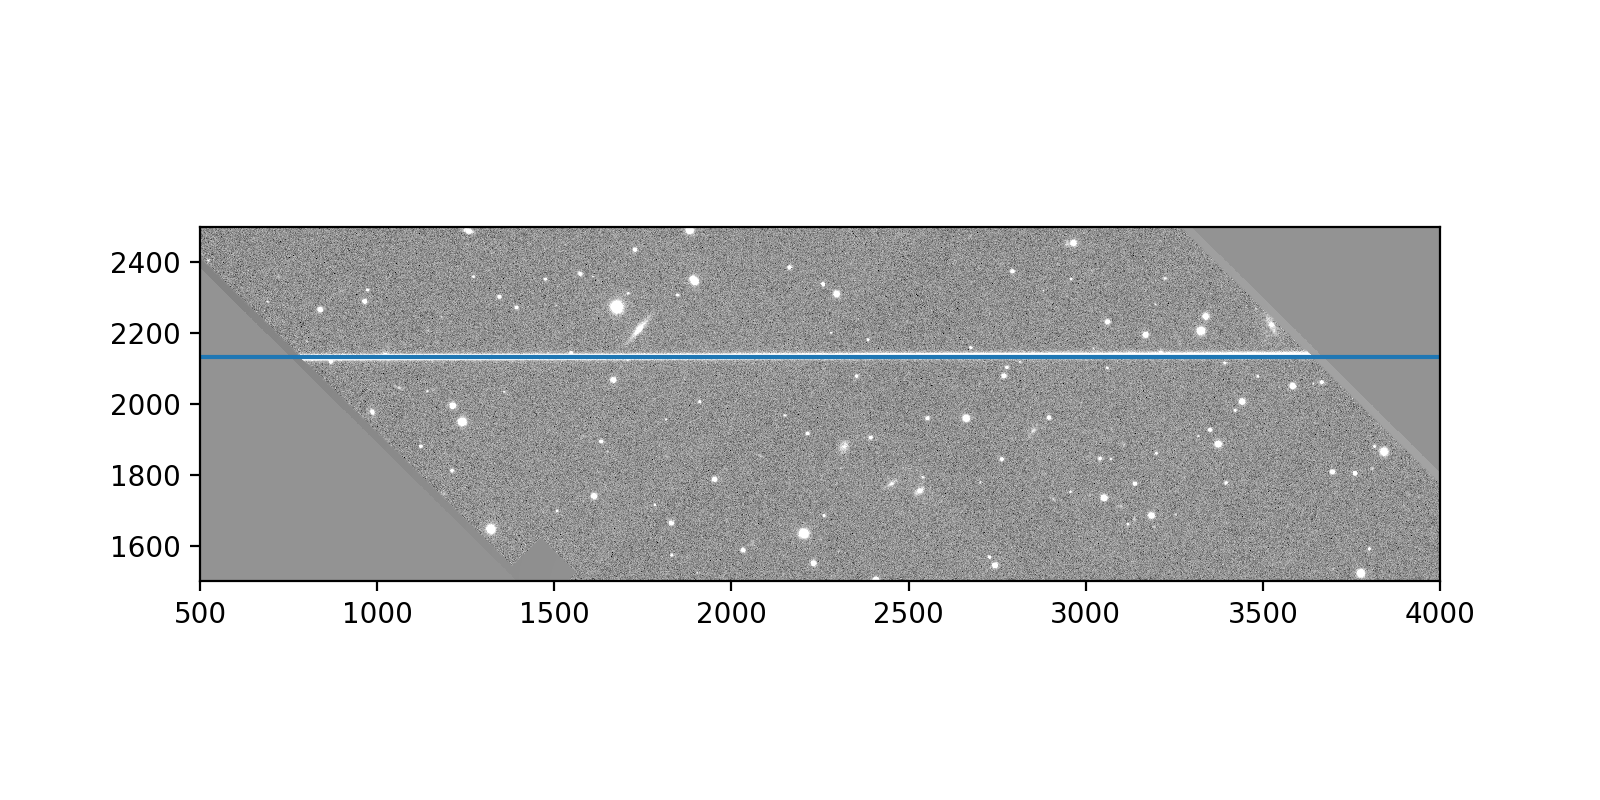

In [260]:
plt.figure(figsize=(8,4))
plt.imshow(rotatedArray, cmap='gray', norm=norm, origin='lower')
plt.gca().set_xlim([500, 4000])
plt.gca().set_ylim([1500, 2500])
plt.axhline(y=2134)

### Plot the line profile
Close, but not perfect

In [247]:
y_trail = 2134  # y-value location of trail in rotated image
y_width = 20  # pixel width of trail
x_start = 1100
x_end = 3500
x_length = x_end - x_start
sliced = rotatedArray[y_trail - y_width:y_trail + width, x_start:x_end]

<IPython.core.display.Javascript object>


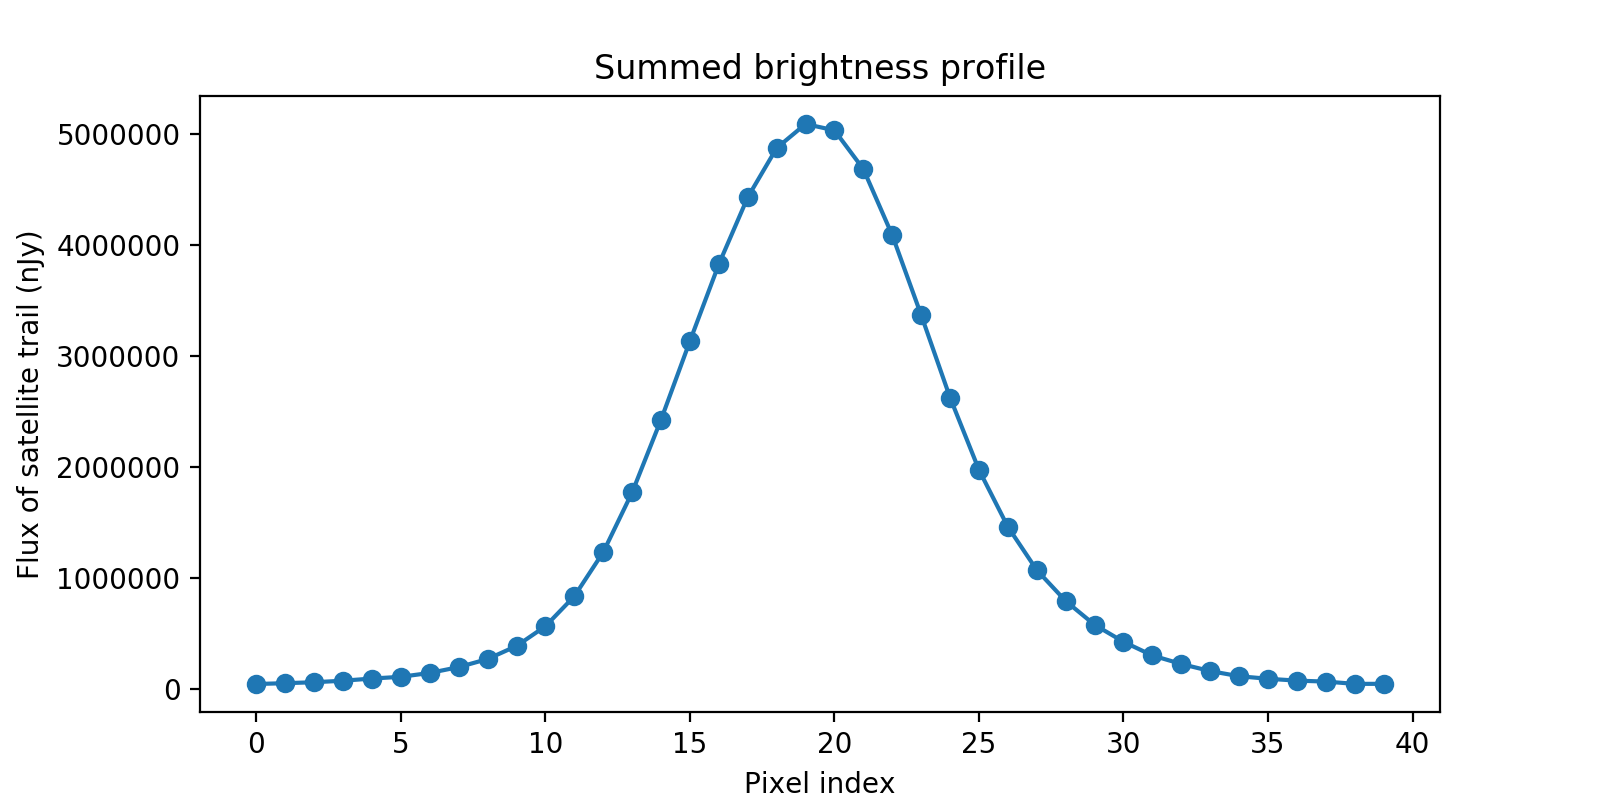

Text(0.5, 1.0, 'Summed brightness profile')

In [263]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots()
ax.plot(sliced.sum(axis=1), marker='o')
plt.xlabel('Pixel index')
plt.ylabel('Flux of satellite trail (nJy)')
plt.title('Summed brightness profile')

<IPython.core.display.Javascript object>


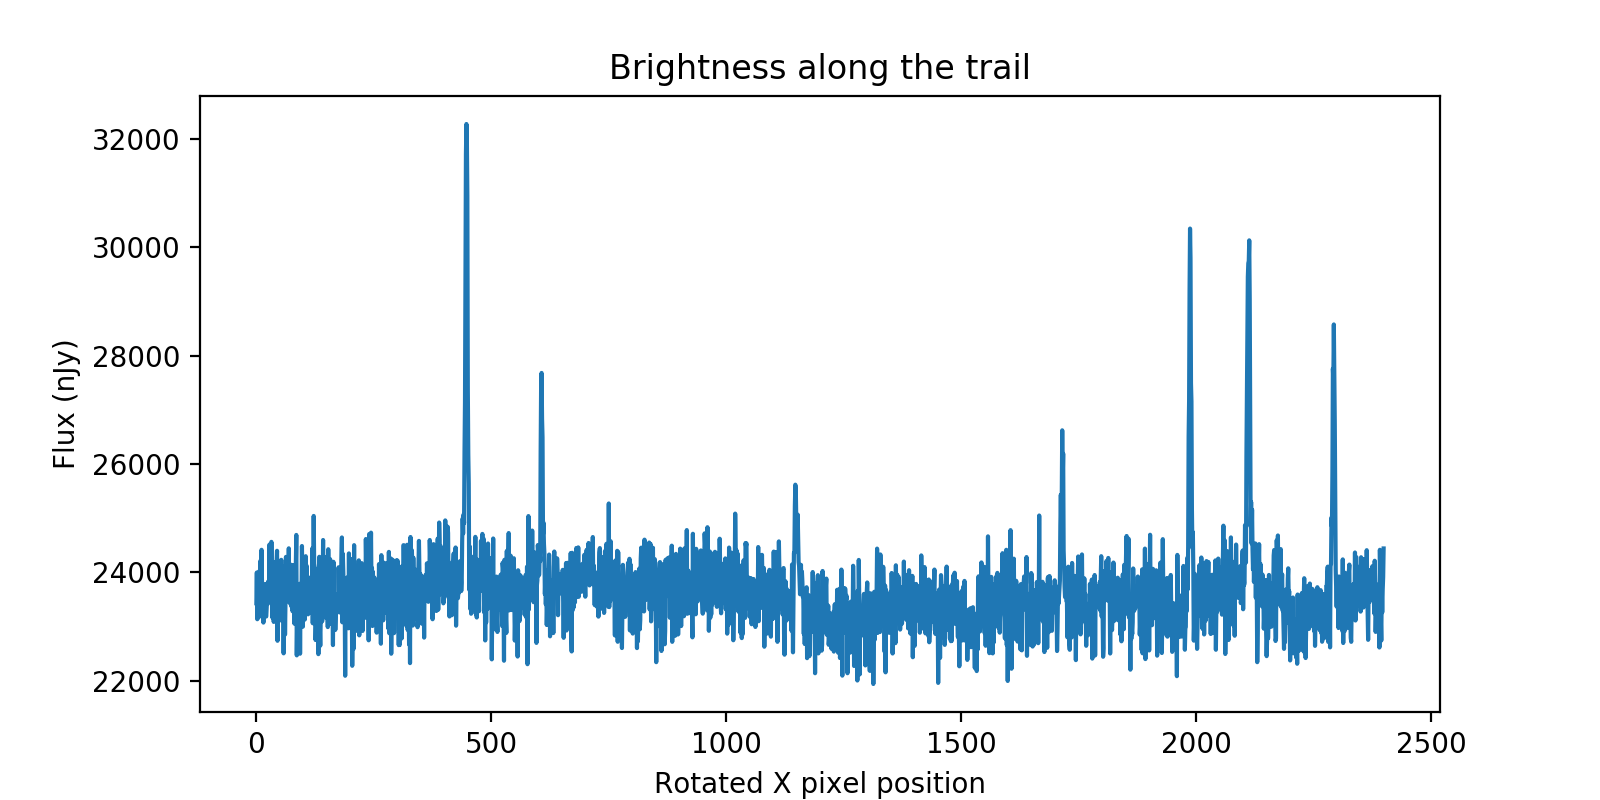

Text(0, 0.5, 'Flux (nJy)')

In [264]:
fig = plt.figure(figsize=(8,4))
ax = fig.subplots()
ax.plot(sliced.sum(axis=0))
plt.title('Brightness along the trail')
plt.xlabel('Rotated X pixel position')
plt.ylabel('Flux (nJy)')
#ax.set_ylim(8500, 10000)

### WIP: something meaningful in magnitudes per arcsec^2?
Extended sources are hard

In [171]:
numerator = (sliced.sum()*u.nJy).to(u.ABmag).value  # magnitude of a chunk of the trail

In [174]:
denominator = y_width*x_length * pixelScale.asArcseconds()**2  # area of the chunk of the trail in arcsec^2

In [177]:
print(numerator)
print(denominator)
numerator/denominator  # I think ?

12.015552637262841
3310.69161149764


0.003629317993718971